# 추론 기반 기법과 신경망

## 통계 기반 기법의 문제점
- 대규모 코퍼스에서 행렬이 지나치게 거대해짐
    - 해결 방법: `추론 기반 학습`
 
## 추론 기반 기법
- `추론`: context -> prediction

## 신경망에서의 단어 처리
- 단어를 처리하기 위한 전처리: 단어 -> **고정 길이의 벡터**
- 대표적 방법: `원핫(one hot) 벡터`
- `one hot vector`: one element=1, others=0

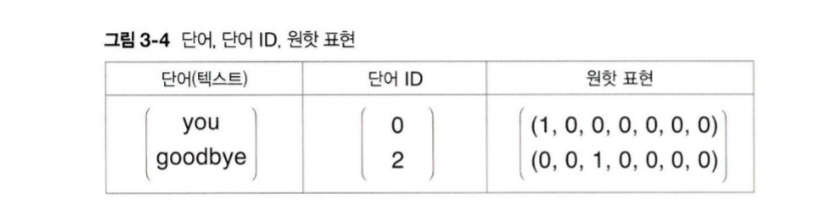

위의 예시에서는 인덱스가 단어 ID와 같은 원소를 1로, 나머지를 0으로 설정한다. 이러한 것이 일종의 단어를 `고정 길이 벡터`로 변환하는 알고리즘이다.

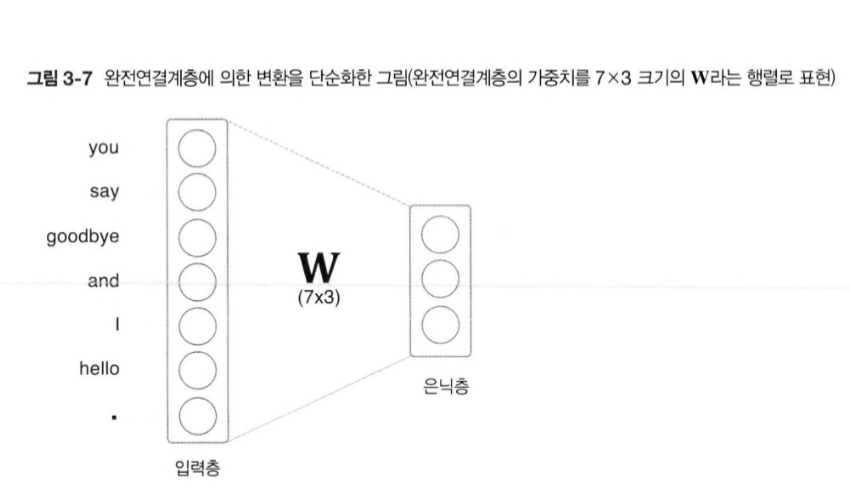

그림의 신경망은 `Fully Connected Layer`, 즉 모든 입력 노드가 모든 출력 노드에 연결되었다.   
W라는 가중치를 통해 입력층 뉴런의 `weighted sum`이 은닉층 뉴런이 된다.

In [1]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) #input
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[-0.09911941  0.47216764 -1.76061392]]


코드에서 확인가능한 점은:
- 단어 ID가 0인 단어를 원핫 표현으로 표현 후 `Fully Connected Layer`를 통과시켜 변환하는 과정
- 위와 같이 `Fully Connected Layer`의 계산은 행렬 곱, 코드에서는 `np.matmul()`이 해줄 것

결과를 보면 알겠지만 행벡터가 출력된다.   
`context` c와 가중치 W의 곱으로 해당 위치의 행벡터가 추출되는 것.   
행벡터만 추출하는 것이기 때문에 행렬 곱보다 더 효율적인 방법이 존재한다.

# Simple word2vec

Two types of word2vec:
- `CBOW`: context -> target
- `Skip Gram`: target -> context

target은 중심 단어이고, context는 그 주변부의 단어들이다.

##  CBOW 추론 처리


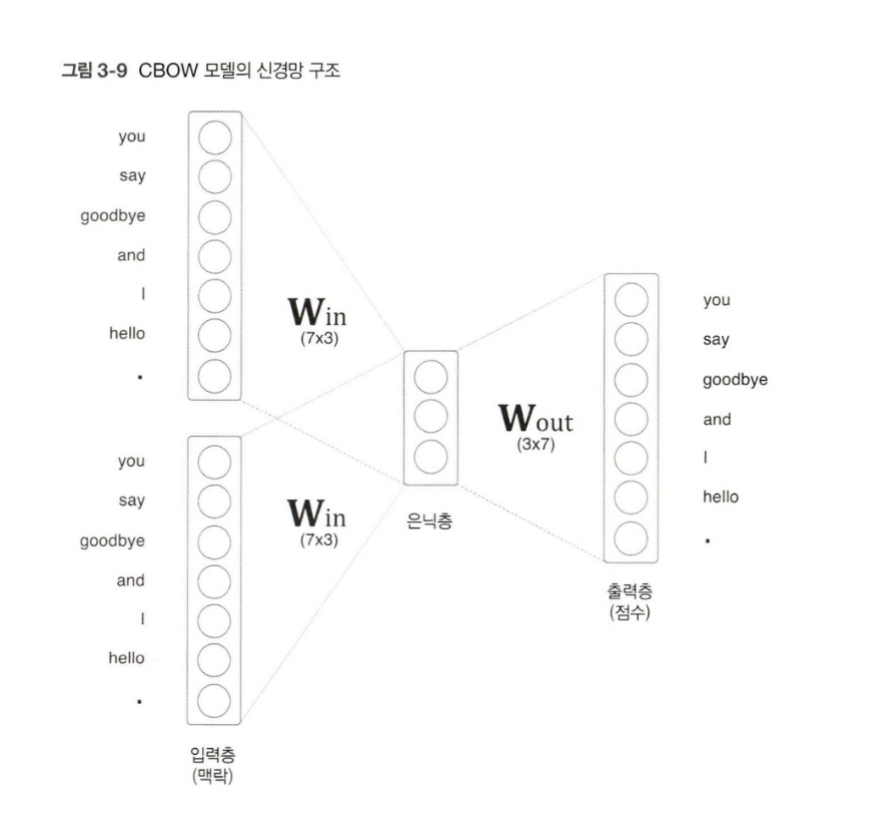

구조:
- `입력층`: context의 단어가 N개라면 입력층 또한 N개
  - context(주변 단어들)의 one-hot vector를 입력으로 받는다
  - example) sentence: "I want to go home" target: "go" context: ("I", "want", "to", "home")
- `은닉층`
  - 임베딩 행렬 $W_{in}$: 고차원 공간->저차원 임베딩
  - 모든 context 단어의 임베딩 벡터의 평균을 계산하여 은닉층의 출력으로 사용
- `출력층`
  - 은닉층의 결과를 가중치 행렬 $W_{out}$에 곱해 중심 단어에 대한 확률 분포 생성
  - Softmax 활성화 함수를 사용해 중심 단어 예측

1. 입력 표현
- C개의 context단어, 각 단어는 원-핫 벡터 $x_{i} (i=1,2,...C)$로 표현
- V: 어휘의 크기
2. 임베딩 변환
- $W = V \times d$ 크기의 임베딩 행렬(d: 임베딩 벡터의 차원)
- $x_{i}$는 $h_{i}$로 변환
- $$h_{i} = W^{T}x_{i}$$ (d차원 벡터)
3. context 벡터 계산
- 모든 context 단어의 벡터를 평균내어 context vector h 생성
- $$h = \frac{1}{C}\sum{i=1}^{C}h_{i}$$
4. 출력 벡터 계산
- $$u = W'h$$
- 가중치 행렬을 사용하여 문맥 벡터 h를 중심 단어의 예측 확률로 변환.
- u는 어휘의 각 단어에 대한 점수가 된다.
5. 확률 계산
- Softmax 함수로 u를 확률 분포로 변환
- $$P(w|context) = \frac{exp(u_{w})}{\sum_{v=1}^{V}exp(u_{v})}$$
6. 손실 함수
- 모델 학습 시 Cross-Entropy Loss를 최소화
- $$L = -\sum logP(w|context)$$

In [6]:
# coding: utf-8
import os
import sys
sys.path.append('os.pathdir')
sys.path.append(os.path.abspath("../common"))
import numpy as np
from layers import MatMul


# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-1.42913051  0.32021914  1.57358761 -0.17697201  1.44817238  0.73293226
   1.51296301]]


## CBOW 학습
가중치가 잘 설정되었다면 확률을 나타내는 뉴런들 중 정답에 해당하는 뉴런의 값이 가장 클 것.   
CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다. 

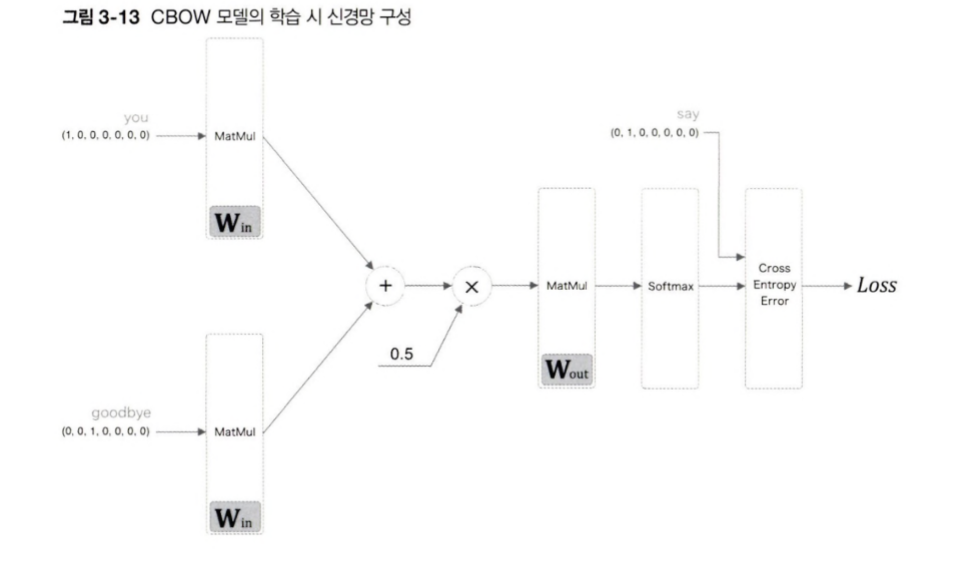

위에 있던 수학적 설명과 같이, 크로스 엔트로피 계층을 추가하여 Loss구하는 것을 보여주고 있다.

##  word2vec의 가중치와 분산 표현

가중치의 분산 표현(Distributed Representation)으로는 세 가지 선택지가 있다:
- 입력 측 가중치
- 출력 측 가중치
- 양쪽 가중치
일반적으로 입력 측 가중치만 사용한다.
사유는 입력 측 가중치가 단어 간 의미적 유사성 학습 및 표현에 초점을 맞추고 있고 출력 측 가중치가 중심 단어의 확률 분포 생성에 더 최적화되어 있기 때문.

# 학습 데이터 준비

## 맥락과 타깃
`contexts`: 여러개
`target`: 한개

In [8]:
import sys
import os
sys.path.append('os.pathdir')
sys.path.append(os.path.abspath("../common"))
from util import preprocess
text = "You say Hello and I say World."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'hello', 3: 'and', 4: 'i', 5: 'world', 6: '.'}


In [12]:
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

## 원핫 표현으로 변환


In [14]:
from util import preprocess, create_contexts_target, convert_one_hot
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)


# CBOW 구현

In [16]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/home/max/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/max/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/max/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/max/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


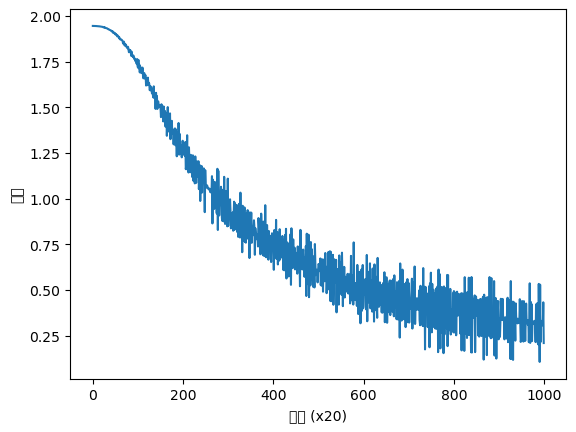

you [-1.2327822 -0.9174203  0.9106257 -0.9037279  1.6625403]
say [-1.3225389   1.1703696  -1.1801302   1.2259222  -0.27435312]
goodbye [-0.64962786 -1.1034697   1.099717   -1.0847814  -0.6461445 ]
and [-1.0119555   0.90119535 -0.88249826  0.8621995  -1.7821681 ]
i [-0.6492675  -1.0810227   1.0672754  -1.0440894  -0.65007937]
hello [-1.2327929  -0.9318559   0.92307055 -0.8994673   1.6619776 ]
. [-1.2637117  1.098263  -1.0796055  1.1312284  1.635919 ]


In [18]:
from trainer import Trainer
from optimizer import Adam
from util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# word2vec 보충
## CBOW 모델과 확률
목적
- 주변 단어(문맥) $( \{ w_{c-k}, \dots, w_{c-1}, w_{c+1}, \dots, w_{c+k} \} )$를 사용해 중심 단어 $( w_c )$를 예측   

입력:
- 문맥 단어 $( \{ w_{c-k}, \dots, w_{c-1}, w_{c+1}, \dots, w_{c+k} \} )$.
- 각 단어 $( w_i )$는 원-핫 벡터 $( x_i \in \mathbb{R}^V )$로 표현 $(( V )$: 어휘 크기).

`임베딩 변환`
- 임베딩 행렬 $( W \in \mathbb{R}^{V \times d} )$를 통해 각 단어의 임베딩 벡터 $( h_i \in \mathbb{R}^d )$를 계산:
  $$
  h_i = W^T x_i
  $$
- 모든 문맥 단어의 임베딩 벡터를 평균화하여 문맥 벡터 \( h \)를 생성:
  $$
  h = \frac{1}{2k} \sum_{i=1}^{2k} h_i
  $$

`출력 계산`
- 문맥 벡터 $( h )$를 출력 가중치 행렬 $( W' \in \mathbb{R}^{d \times V} )$와 곱해 각 단어 $( w )$에 대한 점수 $( u_w )$를 계산:
  $$
  u_w = W'^T h
  $$
- 소프트맥스 함수를 통해 중심 단어 \( w_c \)의 조건부 확률을 계산:
  $$
  P(w_c | context) = \frac{\exp(u_{w_c})}{\sum_{w=1}^V \exp(u_w)}
  $$

`손실 함수`
- 중심 단어 $( w_c )$가 실제 단어와 일치하도록 모델을 학습.
- 손실 함수 $( L )$ (교차 엔트로피 손실):
 $$
  L = - \sum_{w_c \in \text{corpus}} \log P(w_c | context)
  $$


## Skip-Gram

`목적`
- 중심 단어 $( w_c )$를 입력으로, 주변 단어(문맥) $( \{ w_{c-k}, \dots, w_{c-1}, w_{c+1}, \dots, w_{c+k} \} )$를 예측



`입력`:
- 중심 단어 $( w_c )$.
- 중심 단어는 원-핫 벡터 $( x_c \in \mathbb{R}^V )$로 표현 ( $V$: 어휘 크기).

`임베딩 변환`
- 임베딩 행렬 $ (W \in \mathbb{R}^{V \times d} )$를 통해 중심 단어의 임베딩 벡터 $( h \in \mathbb{R}^d )$를 계산:
  $$
  h = W^T x_c
  $$

`출력 계산`
- 임베딩 벡터 $ h $를 출력 가중치 행렬 $ W' \in \mathbb{R}^{d \times V} $와 곱해 각 단어 $ w $에 대한 점수 $ u_w $를 계산:
  $$
  u_w = W'^T h
  $$
- 소프트맥스 함수를 통해 주변 단어 $ w_o $의 조건부 확률을 계산:
  $$
  P(w_o | w_c) = \frac{\exp(u_{w_o})}{\sum_{w=1}^V \exp(u_w)}
  $$

`손실 함수`
- 중심 단어 $w_c$가 주변 단어 $w_o$를 잘 예측하도록 모델을 학습.
- 손실 함수 $L$ (교차 엔트로피 손실):
  $$
  L = - \sum_{(w_c, w_o) \in \text{corpus}} \log P(w_o | w_c)
  $$


| **특징**         | **CBOW**                             | **Skip-Gram**                          |
|------------------|-------------------------------------|---------------------------------------|
| **목표**         | 주변 단어 → 중심 단어               | 중심 단어 → 주변 단어                 |
| **입력**         | 주변 단어                            | 중심 단어                              |
| **출력**         | 중심 단어                            | 주변 단어                              |
| **손실 함수**    | $ L = - \sum \log P(w_c | \text{context}) $ | $ L = - \sum \log P(w_o | w_c) $    |
| **데이터 효율성**| 작은 데이터셋에서 효율적             | 큰 데이터셋에서 효율적                 |
| **희소 단어 학습**| 덜 유리                              | 희소 단어 학습에 더 유리               |


## 통계 기반, 추론 기반, GloVe

`통계 기반 (Statistical Learning)`:
- 코퍼스에서 단어 간 전역적 통계 정보 학습
- 동시 등장 패턴을 통해 학습
 - example: Hello와 World는 자주 함께 등장->유사한 임베딩
- 코퍼스 전체의 통계 정보를 활용하므로 전역적 의미를 잘 포착
- 단어 간 유사성 정량적으로 측정 가능
- 고차원 행렬 계산이 필요->리소스 사용량이 많다

`추론 학습(Predictive Learning)`
- 단어<->문맥 기반 추론
- 효율적 계산
- 전역적 의미를 담기엔 부족할 수도

`Glove`:
- 전역 통계 정보 + 저차원 벡터

1. 동시 등장 행렬:
$X_{ij}$: 단어 i와 j가 함께 등장하는 횟수

2. 비율관계
- 단어 i와 j의 관계는 다른 단어 k에 대한 비율로 표현
$$\frac{P(i|k)}{P(j|k)} = \frac{X_{ik}}{X_{jk}}$$

3. 손실함수
$$J = \sum_{i,j} f(X_{ij})(w_{i}^{T}w_{j} + b_{i} + b_{j} - logX_{ij})^2$$
- $w_{i}$: 단어 i의 임베딩 벡터
- $b_{i}$: 단어 i의 편향
- $f(X_{ij})$: 동시 등장 빈도 $X_{ij}$에 대한 가중치 함수. 빈도 값이 너무 크거나 작을 때 영향 조정


| **특징**          | **GloVe**                                      | **Word2Vec (CBOW/Skip-Gram)**          |
|-------------------|-----------------------------------------------|---------------------------------------|
| **학습 방식**      | 통계적 학습과 추론 학습 결합                   | 추론 학습 (예측 기반)                 |
| **전역 정보 활용** | 전역적 통계 정보 사용                         | 지역적 문맥에 초점                   |
| **효율성**         | 고속 학습 가능                                 | 빠른 학습 가능, 데이터에 민감         |
| **유사성 표현**    | 비율 기반으로 단어 관계를 표현                  | 문맥 기반으로 단어 관계를 표현         |
